$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
$$

In [1]:
%matplotlib inline
from __future__ import division;
import numpy as np;
from matplotlib import pyplot as plt;
from matplotlib import colors
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import mlab;
from matplotlib import gridspec;
import pandas as pd
from IPython.display import display

if "bmh" in plt.style.available: plt.style.use("bmh");

import scipy as scp;

from scipy import linalg

import scipy.stats;

# scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# python
import random;

# warnings
import warnings
warnings.filterwarnings("ignore")

# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll': False

});

## Outline

- Concept of Classification   
- Logistic Regression
    - Intuition, Motivation
    - Newton's Method
- Softmax regression
    
## Reading List

- Required:
    - **[MLAPP]**, Chapter 8: Logistic Regression    

> In this lecture, we will move from regression to classification. Unlike of predicting some value for data in regression, we predict what category data belongs to in classification. And we will introduce two classifiers in this lecture: perceptron and logistic regression. In logistic regression, we will show how to find the optimal coefficients $\vw$ using Newton's method.

## Review: Supervised Learning

- Goal
    - Given data $X$ in feature space and the labels $Y$
    - Learn to predict $Y$ from $X$
- Labels could be discrete or continuous
    - Discrete-valued labels:  Classification
    - Continuous-valued labels:  Regression
    
<center>
<div class="image"   style="width:550px">
    <img src="images/classification-regression.png">
</div>
</center>

## Classification Problem

### Classification Problem: Basics

- Given an input vector $\vx$, assign it to one of $K$ distinct classes $C_k$, where $k = 1,\dots,K$.

- The case $K=2$ is **Binary Classification**
    - Label $t=1$ means $x \in C_1$
    - Label $t=0$ means $x \in C_2$ (or sometimes $t=-1$)
    
- **Training:**  Learn a classifier $y(\vx)$ from data,
    $$ \text{Training Data} \quad \{ (\vx_1, t_1), \dots, (\vx_N, t_N) \} \implies \text{Classifier} \ y(\vx) $$
    
- **Prediction:** Predict labels of new data,
    $$ \text{New Data} \quad \{ (\vx^{new}_1, t^{new}_1), \dots, (\vx^{new}_m, t^{new}_m) \} \stackrel{h}{\implies} \{ y(\vx^{new}_1), \dots, y(x^{new}_m) \} $$

- **Performance Evaluation:** Evaluate learned classifier on test data,
    $$ \text{Test Data} \quad \{ (\vx^{test}_1, t^{test}_1), \dots, (\vx^{test}_m, t^{test}_m) \} \stackrel{y}{\implies} \{ y(\vx^{test}_1), \dots, y(\vx^{test}_m) \} \implies \text{Error Estimate} $$
    - To estimate **classification error**, we could use e.g. *zero-one loss*:
        $$
        E = \frac{1}{m} \sum_{j=1}^m \mathbb{1} [ y(\vx^{test}_j) \neq t^{test}_j) ]
        $$
        i.e. number of misclassified data.

### Classification Problems:  Strategies

- **Nearest-Neighbors:**  Given query data $\vx$, find closest training points and do a majority vote.

- **Discriminant Functions:**  Learn a function $y(\vx)$ mapping $\vx$ to some class $C_k$.

- **Probabilistic Model:**  Learn the distributions $P(C_k | \vx)$
    - *Discriminative Models* directly model $P(C_k | \vx)$ and learn parameters from the training set.
    - *Generative Models* learn class-conditional densities $P(\vx | C_k)$ and priors $P(C_k)$

## Logistic Regression
> - Logistic Regression is a technique for **classification**!

> - We will focus on *binary* classification

### Logistic Regression: Preliminary—Logistic Sigmoid Function

Let’s now talk about the classification problem. This is just like the regression
problem, except that the values $y$ we now want to predict take on only
a small number of discrete values. For now, we will focus on the binary
classification problem in which y can take on only two values, $0$ and $1$.
(Most of what we say here will also generalize to the multiple-class case.)
For instance, if we are trying to build a spam classifier for email, then $x^{(i)}$ may be some features of a piece of email, and y may be $1$ if it is a piece
of spam mail, and 0 otherwise. $0$ is also called the negative class, and $1$ the positive class, and they are sometimes also denoted by the symbols “$-$” and “$+$.” Given $x^{(i)}$, the corresponding $y^{(i)}$ is also called the label for the training example.


We could approach the classification problem ignoring the fact that $y$ is
discrete-valued, and use our old linear regression algorithm to try to predict
$y$ given $x$. However, it is easy to construct examples where this method
performs very poorly. Intuitively, it also doesn’t make sense for $h_{\theta}(x)$ to take
values larger than $1$ or smaller than $0$ when we know that $y\in{0, 1}$.
To fix this, let’s change the form for our hypotheses $h_{\theta}(x)$. We will choose

$$h_{\theta} = g(\theta^Tx) = \frac{1}{1+\exp{(-\theta^Tx)}}$$

where

$$g(z) = \frac{1}{1+\exp{(-z)}}$$

and $z = \theta^Tx$. $g$ is called the logistic function or the sigmoid function. Here is a plot
showing $g(z)$:


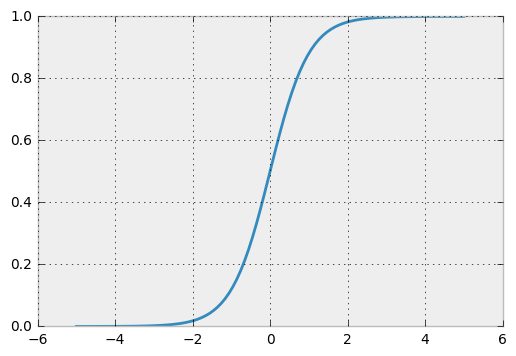

In [20]:
def logistic(theta, x):
    return 1. / (1 + np.exp(-theta * x))

# Define derivative of the logistic function
def logistic_derivative(theta, x):
    return logistic(theta, x) * (1 - logistic(theta, x))


theta = 2
x = np.linspace(-5, 5, 100)

plt.plot(x, logistic(theta, x))
plt.show()

Notice that $g(z)$ tends towards $1$ as $z\rightarrow \infty$, and $g(z)$ tends towards $0$ as
$z\rightarrow -\infty$. Moreover, $g(z)$, and hence also $h(x)$, is always bounded between
$0$ and $1$. As before, we are keeping the convention of letting $x_0 = 1$, so that we can write $\theta_0 + \sum_{i=1}^{m}\theta_ix_i = \theta^Tx$.  Before moving on, here’s a useful property of the derivative of the sigmoid function, which we write as $g'$:

\begin{align*}
g'(z) &= \frac{d}{dz}\frac{1}{1+\exp{(-z)}}\\
&= \frac{1}{(1+\exp{(-z))^2}}\exp(-z)\\
&= \frac{1}{1+\exp(-z)} . \big(1-\frac{1}{1+\exp(-z)}\big)\\
&= g(z).(1-g(z))
\end{align*}

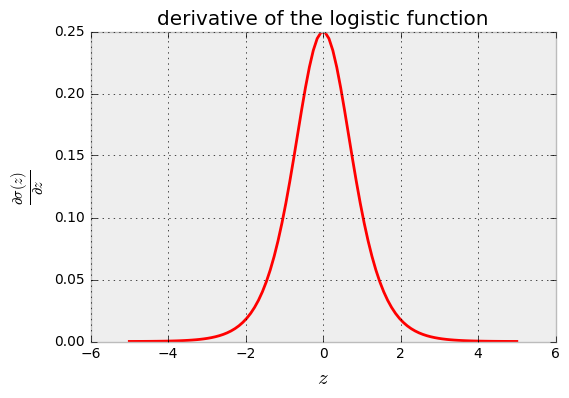

In [21]:
# Plot the derivative of the logistic function
plt.plot(x, logistic_derivative(theta, x), 'r-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$\\frac{\\partial \\sigma(z)}{\\partial z}$', fontsize=15)
plt.title('derivative of the logistic function')
plt.show()

So, given the logistic regression model, how do we fit $\theta$ for it?  Following
how we saw least squares regression could be derived as the maximum likelihood
estimator under a set of assumptions, let’s endow our classification
model with a set of probabilistic assumptions, and then fit the parameters
via maximum likelihood. Let us assume

\begin{align*}
P(y=1|x;\theta) &= h_{\theta}(x)\\
P(y=0|x;\theta) &= 1 - h_{\theta}(x)
\end{align*}

Note that this can be written more compactly as

$$P(y|x;\theta) = (h_{\theta}(x))^y \;(1 - h_{\theta}(x))^{1-y}$$

Assuming that the m training examples were generated independently, we
can then write down the likelihood of the parameters as

\begin{align*}
L(\theta) &= p(\hat{y}|X;\theta)\\
&= \prod_{i=1}^m p(y^{(i)}|x^{(i)};\theta)\\
&= \prod_{i=1}^m (h_{\theta}(x^{(i)}))^{y^{(i)}} \;(1 - h_{\theta}(x^{(i)}))^{1-y^{(i)}}
\end{align*}

As before, it will be easier to maximize the log likelihood:
\begin{align*}
\ell(\theta) &= log\;L(\theta)\\
&= \sum_{i=1}^m {y^{(i)}}log\;(h_{\theta}(x^{(i)})) + (1-y^{(i)})\;log\;(1 - h_{\theta}(x^{(i)}))
\end{align*}

How do we maximize the likelihood? Similar to our derivation in the case
of linear regression, we can use gradient ascent. Written in vectorial notation,
our updates will therefore be given by $\theta = \theta + \alpha\nabla_{\theta}\ell(\theta)$. (Note the positive
rather than negative sign in the update formula, since we’re maximizing,
rather than minimizing, a function now.) Let’s start by working with just
one training example $(x, y)$, and take derivatives to derive the stochastic
gradient ascent rule:

\begin{align*}
\frac{\partial}{\partial\theta_j}\ell(\theta) &= \frac{\partial}{\partial\theta} \big[{y}\;log\;(h_{\theta}(x)) + (1-y)\;log\;(1 - h_{\theta}(x))\big]\\
&= \big[ {y}\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{(1 - g(\theta^Tx))} \big]\;\frac{\partial}{\partial\theta} g(\theta^Tx)\\
&= \big[ {y}\frac{1}{g(\theta^Tx)} - (1-y)\frac{1}{(1 - g(\theta^Tx))} \big]\; (g(\theta^Tx).(1-g(\theta^Tx)))\frac{\partial}{\partial\theta}\theta^T x \\
&= \big[ {y}(1 - g(\theta^Tx)) - (1-y)g(\theta^Tx) \big]\;x_j\\
&= \big[y - yg(\theta^Tx) - g(\theta^Tx) + yg(\theta^Tx) \big]\;x_j\\
&= \big[y - h_{\theta}(x)\big]\;x_j
\end{align*}

Using the above equation, we derive the gradient descent algorithm for logistic regression:

\begin{align}
repeat \{\\
&\theta_j = \theta_j - \alpha \frac{1}{m}\sum_{i=1}^m(y^{(i)} - h_{\theta}(x^{(i)})).x^{(i)}_j\\
\}
\end{align}

#### Regularized logistic regression

\begin{align*}
min_{\theta}\;J(\theta)= \big[-\frac{1}{m} \sum_{i=1}^m {y^{(i)}}log\;(h_{\theta}(x^{(i)})) + (1-y^{(i)})\;log\;(1 - h_{\theta}(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^m \theta_j^2
\end{align*}

\begin{align}
repeat \{\\
&\theta_0 = \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^m(y^{(i)} - h_{\theta}(x^{(i)})).x^{(i)}_0\\
&\theta_j = \theta_j - \alpha\big[\frac{1}{m}\sum_{i=1}^m(y^{(i)} - h_{\theta}(x^{(i)})).x^{(i)}_j-\frac{\lambda}{m}\theta_j\big]\\
\}
\end{align}

### Logistic Regression:  Why use Logistic Sigmoid Function?
- Prediction is picking the larger one of $P(y=1 | \vx)$ and $P(y=0 | \vx)$.

- This can be implemented by evaluating **log odds**
    $$
    a = \ln \frac{P(y=1 | \vx)}{P(y=0  | \vx)}
    $$
    
- So the prediction is
    $$
    y = 
    \left\{\begin{matrix}
    1& a\geq 0\\
    0& a< 0
    \end{matrix}\right.
    $$    
    
- Since $P(y=1 | \vx) + P(y=0  | \vx)=1$, we could solve for
    $$
    P(y=1 | \vx) = \frac{\exp(a)}{1+\exp(a)} = \sigma(a)
    $$ 
    *Logistic Function* appears!   

- A heuristic choice for log odds is a separating **hyper plane** $a = \vw^T \phi(\vx)$. So the criterion becomes
    $$
    \boxed{
    y = 
    \left\{\begin{matrix}
    1& \vw^T \phi(\vx)\geq 0, \quad \text{i.e.} \quad \sigma(\vw^T\phi(\vx)\geq 0) \geq 0.5\\
    0& \vw^T \phi(\vx)< 0 , \quad \text{i.e.} \quad \sigma(\vw^T\phi(\vx)\geq 0) < 0.5
    \end{matrix}\right.}
    $$
    
- In this case, $P(y=1 | \vx) = \sigma(\vw^T \phi(\vx))$ and $P(y=0 | \vx) = 1-\sigma(\vw^T \phi(\vx))$.

### Logistic Regression: Underlying Model

- We already have
    $$
    \begin{align}
    P(y=1 | \vx, \vw) &= \sigma(\vw^T \phi(\vx)) \\
    P(y=0 | \vx, \vw) &= 1-\sigma(\vw^T \phi(\vx))
    \end{align}
    $$

- So we could model **class posterior** using Bernoulli random variable
    $$
    y | \vx ,\vw \sim \mathrm{Bernoulli}( \sigma(\vw^T \phi(\vx)) )
    $$

- We can obtain the best parameter $\vw$ by maximizing the likelihood of the training data.(Later)

- Logistic regression is simplest discriminative model that is **linear**
in the parameters.

### Logistic Regression: Example

In this example the target classes $t$ will be generated from 2 class distributions: blue ($t=1$) and red ($t=0$). Samples from both classes are sampled from their respective distributions. These samples are plotted in the figure below.
Note that $X$ is a $N \times 2$ matrix of individual input samples $\mathbf{x}_i$, and that $\mathbf{t}$ is a corresponding $N \times 1$ vector of target values $t_i$.

In [17]:
np.random.seed(seed=1)

# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
red_mean = [-1, 0]  # The mean of the red class
blue_mean = [1, 0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of output variables t
X = np.vstack((x_red, x_blue))
t = np.vstack((np.zeros((nb_of_samples_per_class, 1)), np.ones(
    (nb_of_samples_per_class, 1))))

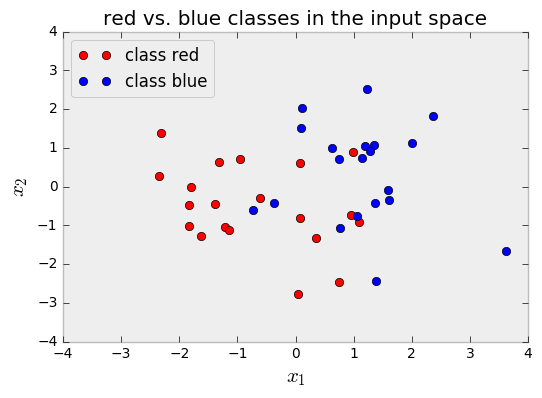

In [18]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label='class red')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()

- We could clearly see the linear boundary corresponding to $\vw^T \phi(\vx)$

### Logistic Regression:  Likelihood

- We saw before that the **likelihood** for each binary label is:
    $$
    \begin{align}
    P(y = 1 | \vx,\vw) &= \sigma(\vw^T \phi(\vx)) \\
    P(y = 0 | \vx,\vw) &= 1 - \sigma(\vw^T \phi(\vx))
    \end{align}
    $$
- With a clever trick, this
    $$
    P(y | x,w) = \sigma(\vw^T \phi(\vx))^y \cdot (1 - \sigma(\vw^T \phi(\vx)))^{1-y}
    $$

- For a data set $\{(\vx_n, t_n) \}_{n=1}^N$ where $t_n \in \{ 0,1 \}$, the **likelihood function** is
    $$
    P(\vy = \vt| \mathcal{X}, \vw) = \prod_{n=1}^N P(y=t_n | \vx_n, \vw) =\prod_{n=1}^N \sigma(\vw^T \phi(\vx_n))^{t_n} [1 - \sigma(\vw^T \phi(\vx_n))] ^{1-t_n}
    $$
    - where $\mathcal{X} = \{\vx_n \}_{n=1}^N$

- The optimal $\vw$ can be obtained by maximizing this likelihood.

- Maximum likelihood estimate $\vw_{ML}$ makse sense because $\vw_{ML}$ is the coefficient that are most likely to produce $\{t_n \}_{n=1}^N$ given $\mathcal{X}$.

- Define **negative log-likelihood** as the **loss**
    $$
    E(\vw) \triangleq -\ln P(\vy = \vt| \mathcal{X}, \vw)
    $$
- Maximizing **likelihood** is equivalent to minimizing **loss** $E(\vw)$

### Logistic Regression:  Gradient of Loss

- Loss function $E(\vw)$ can be transformed:
    $$
    \begin{align}
    E(\vw) 
    &= -\ln P(\vy = \vt| \mathcal{X}, \vw) \\
    &= -\ln \prod \nolimits_{n=1}^N \sigma(\vw^T \phi(\vx_n))^{t_n} [1 - \sigma(\vw^T \phi(\vx_n))] ^{1-t_n} \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \sigma(\vw^T \phi(\vx_n)) + (1-t_n) \ln(1-\sigma(\vw^T \phi(\vx_n))) \right] \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \frac{\exp(\vw^T\phi(\vx_n))}{1+\exp(\vw^T\phi(\vx_n))} + (1-t_n) \ln(\frac{1}{1+\exp(\vw^T\phi(\vx_n))}) \right] \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \frac{1}{1+\exp(-\vw^T\phi(\vx_n))} + (1-t_n) \ln(\frac{1}{1+\exp(\vw^T\phi(\vx_n))}) \right] \\
    &= \boxed{\sum \nolimits_{n=1}^N \left[ t_n \ln (1+\exp(-\vw^T\phi(\vx_n))) + (1-t_n) \ln(1+\exp(\vw^T\phi(\vx_n))) \right] }\\
    \end{align}
    $$

- Gradient of loss $\nabla_\vw E(\vw)$
    $$
    \begin{align}
    \nabla_\vw E(\vw)
    &= \nabla_\vw \sum \nolimits_{n=1}^N \left[ t_n \ln (1+\exp(-\vw^T\phi(\vx_n))) + (1-t_n) \ln(1+\exp(\vw^T\phi(\vx_n))) \right] \\
    &= \sum \nolimits_{n=1}^N \left[-t_n \frac{\exp(-\vw^T\phi(\vx_n))}{1+\exp(-\vw^T\phi(\vx_n))} \phi(\vx_n)+ (1-t_n) \frac{\exp(\vw^T\phi(\vx_n))}{1+\exp(\vw^T\phi(\vx_n))} \phi(\vx_n) \right] \\
    &= \sum \nolimits_{n=1}^N \left[-t_n (1-\sigma(\vw^T\phi(\vx_n)))+ (1-t_n) \sigma(\vw^T\phi(\vx_n)) \right] \phi(\vx_n) \\
    &= \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) \\
    &= \boxed{ \Phi^T \left( \sigma(\Phi \vw) - \vt \right) }
    \end{align}
    $$
    of which
    $$
    \Phi = \begin{bmatrix} - & \phi(\vx_1)^T & -\\  & \vdots & \\  - & \phi(\vx_N)^T & - \end{bmatrix}_{N \times M}
    \qquad
    \sigma(\Phi \vw)=\begin{bmatrix}
    \sigma(\vw^T\phi(\vx_1))\\ 
    \vdots\\
    \sigma(\vw^T\phi(\vx_N))
    \end{bmatrix}_{N \times 1}
    \qquad
    \vt = \begin{bmatrix}
    t_1\\ 
    \vdots\\
    t_N
    \end{bmatrix}_{N \times 1}
    $$   
    
- With the gradient of loss, we could perform *gradient descent* to find $\vw_{ML}$.

- But we will use a new method by finding roots of first order derivative!

> Remark
> - Note that this gradient resembles the gradient in linear regression with least squares (Check Lecture 4)
    $$
    \begin{align}
    \text{Logistic Regression} \quad & \nabla_\vw E(\vw) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right) \\
    \text{Linear Regression} \quad & \nabla_\vw E(\vw) = \Phi^T \left( \Phi \vw - \vt \right)
    \end{align}
    $$

### Newton's Method: Finding Stationary Point

- We have shown how to use Newton's method to find the root for $f(x)$
    $$
    x_{n+1}= x_n - \frac{f(x_n)}{f'(x_n)}
    $$

- **Note** that Stationary point of $f(x)$ is equivalent to root of $f'(x)$

- So, we could find stationary point of $f(x)$ by finding root of $f'(x)$ using Newton's method.

- The iteration steps becomes
    $$
    x_{n+1}= x_n - \frac{f'(x_n)}{f''(x_n)}
    $$
    
- For *multi-dimension* case, this iteration turns into
    $$
    \vx_{n+1}= \vx_n - \left(\nabla^2 f(\vx_n)\right)^{-1} \nabla_\vx f(\vx_n)
    $$
    of which $\nabla^2 f(\vx_n)$ is **Hessian matrix** which is the *second order derivative*
    $$
    \nabla^2 f = \begin{bmatrix}
    \frac{\partial f}{\partial x_1\partial x_1} & \cdots & \frac{\partial f}{\partial x_1\partial x_n}\\ 
    \vdots & \ddots & \vdots\\ 
    \frac{\partial f}{\partial x_n\partial x_1} & \cdots & \frac{\partial f}{\partial x_n\partial x_n}
    \end{bmatrix}
    $$

### Logistic Regression: Applying Newton's Method

- Back to logistic regression!

- Recall our goal to minimize $E(\vw)$ and we already have its gradient
    $$
    \nabla_\vw E(\vw) = \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right)
    $$
    
- To minimize of $E(\vw)$, we could use Newton's method to find its *stationary point*!

- To use Newton's method, we need the *Hessian matrix*.

### Logistic Regression: Hessian Matrix
$$
\begin{align}
\nabla_{\vw}^2 E(\vw) 
&= \nabla_\vw \nabla_\vw E(\vw) \\
&= \nabla_\vw \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \nabla_\vw \sigma(\vw^T\phi(\vx_n))  \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \nabla_\vw  \frac{1}{1 + \exp(-\vw^T \phi(\vx_n))}  \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) \frac{\exp(-\vw^T \phi(\vx_n))}{(1 + \exp(-\vw^T \phi(\vx_n)))^2}  \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) \frac{1}{1 + \exp(-\vw^T \phi(\vx_n))} \frac{\exp(-\vw^T \phi(\vx_n))}{1 + \exp(-\vw^T \phi(\vx_n))}   \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) [\sigma(\vw^T \phi(\vx_n)) \cdot ( 1 - \sigma(\vw^T \phi(\vx_n)) )]  \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) r_n(\vw) \phi(\vx_n)^T
\end{align}
$$
    
- of which $r_n(\vw) = \sigma(\vw^T \phi(\vx_n)) \cdot ( 1 - \sigma(\vw^T \phi(\vx_n)) )$

$$
\begin{align}
\nabla_{\vw}^2  E(\vw) 
&= \sum \nolimits_{n=1}^N \phi(\vx_n) r_n(\vw) \phi(\vx_n)^T \\
&= \begin{bmatrix}
| &  & | \\ 
\phi(\vx_1) & \cdots & \phi(\vx_N)\\ 
| &  & |
\end{bmatrix}
\begin{bmatrix}
r_1(\vw) &  & \\ 
 & \ddots & \\ 
 &  & r_N(\vw)
\end{bmatrix}
\begin{bmatrix}
- & \phi(\vx_1)^T & -\\ 
 & \vdots & \\ 
- & \phi(\vx_N)^T & -
\end{bmatrix} \\
&= \boxed{\Phi^T R(\vw) \Phi}
\end{align}
$$

- of which
    $$
    R(\vw) = \begin{bmatrix}
    r_1(\vw) &  &  & \\ 
     & r_2(\vw) &  & \\ 
     &  & \ddots & \\ 
     &  &  & r_N(\vw)
    \end{bmatrix}
    $$
    

### Logistic Regression: Applying Newton's Method

- We already have
    $$
    \begin{gather}
    \nabla_\vw E(\vw) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right) \\
    \nabla_{\vw}^2  E(\vw) = \Phi^T R(\vw) \Phi
    \end{gather}
    $$
    
- So the iteration step is
    $$
    \begin{align}
    \vw_{n+1}
    &= \vw_n - \left(\nabla_{\vw}^2  E(\vw_n)\right)^{-1} \nabla_\vw f(\vw_n) \\
    &= \boxed{\vw_n - \left(\Phi^T R(\vw_n) \Phi \right)^{-1} \Phi^T \left( \sigma(\Phi \vw_n) - \vt \right)}
    \end{align}
    $$
    
- Repeat until convergence and we could get maximum likelihood estimate $\vw_{ML}$ which minimizes the loss function $E(\vw)$ and maximizes likelihood function $ P(\vy = \vt| \mathcal{X}, \vw)$

### Logistic Regression: Do we have closed-form solution?

- Recall for **ordinary least squares** and **regularized least squares**, we have closed-form solution:

|               | Ordinary Least Squares  |  Regularized Least Squares |
| ------------- | :-------------: | :-------------: |
| **Derivate of Loss Function** | $\Phi^T\Phi \vec{w} - \Phi^T \vec{t}$ | $(\Phi^T \Phi + \lambda I)\vec{w} - \Phi^T \vec{t}$ |
| **Closed-form Solution**      | $(\Phi^T \Phi)^{-1} \Phi^T \vec{t}$   | $(\Phi^T \Phi + \lambda I)^{-1} \Phi^T \vec{t}$     |

- They are obtained by finding the closed-form root of derivative of loss function。

- For logistic regression, we have
    $$
    \begin{gather}
    \nabla_\vw E(\vw) = 0 \\
    \Downarrow \\
    \Phi^T \left( \sigma(\Phi \vw) - \vt \right) = 0
    \end{gather}
    $$
    
- Existence of sigmoid function makes $\nabla_\vw E(\vw)$ **nonlinear** and no closed-form solution exists.

- So we must **iterate**!

### Multi-class Classification using Logistic Regression

- We have seen sigmoid function enables us to do binary classification with logistic regression.

- What if we want have multiple classes?

- We will resort to **softmax** aka **normalized exponential** function

- **Softmax Function**
    $$
    p_k = \frac{\exp(q_k)}{\sum_j \exp(q_j)}
    $$
    Given any real numbers $q_1, \ldots, q_n$, we can generate a distribution on them using softmax function.
    
- Recall in binary case, we have
    $$
    P(y = 1 | \vx,\vw) = \sigma(\vw^T \phi(\vx))
    $$
    

- For K-class classification, we define $\mathcal{W} = {\vw}_{k=1}^K$. 

- The probability data $\vx$ belongs to class $j$ is
    $$
    P(y = j | \vx,\mathcal{W}) = \frac{\exp(\vw_j^T \phi(\vw))}{\sum_{k=1}^{K} \exp(\vw_k^T \phi(\vw))}
    $$
    
- We classify using
    $$
    y = \underset{j \in \{1,\dots, K\}}{\arg \max} P(y = j | \vx,\mathcal{W})
    $$
    
- Similarly, $\mathcal{W} = {\vw}_{k=1}^K$ is learned by maximizing likelihood function.

- For details, please refer to [this](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression)

## Softmax regression
Softmax regression (or multinomial logistic regression) is a generalization of logistic regression to the case where we want to handle multiple classes. In logistic regression we assumed that the labels were binary: $y^{(i)} \in \{0,1\}$. We used such a classifier to distinguish between two kinds of hand-written digits. Softmax regression allows us to handle $y^{(i)} \in \{1,\ldots,K\}$ where $K$ is the number of classes.

Recall that in logistic regression, we had a training set $\{ (x^{(1)}, y^{(1)}), \ldots, (x^{(m)}, y^{(m)}) \}$ of $m$ labeled examples, where the input features are $x^{(i)} \in \Re^{n}$. With logistic regression, we were in the binary classification setting, so the labels were $y^{(i)} \in \{0,1\}$. Our hypothesis took the form:
\begin{align*}
h_\theta(x) = \frac{1}{1+\exp(-\theta^\top x)},
\end{align*}
and the model parameters $\theta$ were trained to minimize the cost function
\begin{align*}
J(\theta) = -\left[ \sum_{i=1}^m y^{(i)} \log h_\theta(x^{(i)}) + (1-y^{(i)}) \log (1-h_\theta(x^{(i)})) \right]
\end{align*}
In the softmax regression setting, we are interested in multi-class classification (as opposed to only binary classification), and so the label $y$ can take on $K$ different values, rather than only two. Thus, in our training set $\{ (x^{(1)}, y^{(1)}), \ldots, (x^{(m)}, y^{(m)}) \}$, we now have that $y^{(i)} \in \{1, 2, \ldots, K\}$. (Note that our convention will be to index the classes starting from 1, rather than from 0.) For example, in the MNIST digit recognition task, we would have $K=10$ different classes.

Given a test input $x$, we want our hypothesis to estimate the probability that $P(y=k | x)$ for each value of $k = 1, \ldots, K$. I.e., we want to estimate the probability of the class label taking on each of the $K$ different possible values. Thus, our hypothesis will output a $K$-dimensional vector (whose elements sum to 1) giving us our $K$ estimated probabilities. Concretely, our hypothesis $h_{\theta}(x)$ takes the form:
\begin{align*}
h_\theta(x) =
\begin{bmatrix}
P(y = 1 | x; \theta) \\
P(y = 2 | x; \theta) \\
\vdots \\
P(y = K | x; \theta)
\end{bmatrix}
=
\frac{1}{ \sum_{j=1}^{K}{\exp(\theta^{(j)\top} x) }}
\begin{bmatrix}
\exp(\theta^{(1)\top} x ) \\
\exp(\theta^{(2)\top} x ) \\
\vdots \\
\exp(\theta^{(K)\top} x ) \\
\end{bmatrix}
\end{align*}
Here $\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(K)} \in \Re^{n}$ are the parameters of our model. Notice that the term $\frac{1}{ \sum_{j=1}^{K}{\exp(\theta^{(j)\top} x) } }$ normalizes the distribution, so that it sums to one.

For convenience, we will also write $\theta$ to denote all the parameters of our model. When you implement softmax regression, it is usually convenient to represent $\theta$ as a $n$-by-$K$ matrix obtained by concatenating $\theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(K)}$ into columns, so that
\begin{align*}
\theta = \left[\begin{array}{cccc}| & | & | & | \\
\theta^{(1)} & \theta^{(2)} & \cdots & \theta^{(K)} \\
| & | & | & |
\end{array}\right].
\end{align*}

### Cost Function
We now describe the cost function that we’ll use for softmax regression. In the equation below, $1\{\cdot\}$ is the ”‘indicator function,”’ so that $1\{\hbox{a true statement}\}=1$, and $1\{\hbox{a false statement}\}=0$. For example, $1\{2+2=4\}$ evaluates to 1; whereas $1\{1+1=5\}$ evaluates to 0. Our cost function will be:
\begin{align*}
J(\theta) = - \left[ \sum_{i=1}^{m} \sum_{k=1}^{K}  1\left\{y^{(i)} = k\right\} \log \frac{\exp(\theta^{(k)\top} x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)})}\right]
\end{align*}
Notice that this generalizes the logistic regression cost function, which could also have been written:
\begin{align*}
J(\theta) &= - \left[ \sum_{i=1}^m   (1-y^{(i)}) \log (1-h_\theta(x^{(i)})) + y^{(i)} \log h_\theta(x^{(i)}) \right] \\
&= - \left[ \sum_{i=1}^{m} \sum_{k=0}^{1} 1\left\{y^{(i)} = k\right\} \log P(y^{(i)} = k | x^{(i)} ; \theta) \right]
\end{align*}
The softmax cost function is similar, except that we now sum over the $K$ different possible values of the class label. Note also that in softmax regression, we have that $P(y^{(i)} = k | x^{(i)} ; \theta) = \frac{\exp(\theta^{(k)\top} x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)}) }$
We cannot solve for the minimum of $J(\theta)$ analytically, and thus as usual we’ll resort to an iterative optimization algorithm. Taking derivatives, one can show that the gradient is:
\begin{align*}
\nabla_{\theta^{(k)}} J(\theta) = - \sum_{i=1}^{m}{ \left[ x^{(i)} \left( 1\{ y^{(i)} = k\}  - P(y^{(i)} = k | x^{(i)}; \theta) \right) \right]  }
\end{align*}
Recall the meaning of the $\nabla_{\theta^{(k)}}$ notation. In particular, $\nabla_{\theta^{(k)}} J(\theta)$ is itself a vector, so that its $j^{th}$ element is $\frac{\partial J(\theta)}{\partial \theta_{lk}}$ the partial derivative of $J(\theta)$ with respect to the $j^{th}$ element of $\theta^{(k)}$.

Armed with this formula for the derivative, one can then plug it into a standard optimization package and have it minimize $J(\theta)$. When implementing softmax regression, we will typically use a modified version of the cost function described above;
specifically, one that incorporates weight decay.  We describe the motivation and details below.

### Properties of softmax regression parametrization
Softmax regression has an unusual property that it has a “redundant” set of parameters. To explain what this means, suppose we take each of our parameter vectors $\theta^{(j)}$, and subtract some fixed vector $\psi$ from it, so that every $\theta^{(j)}$ is now replaced with $\theta^{(j)} - \psi$ (for every $j=1, \ldots, k$). Our hypothesis now estimates the class label probabilities as.
\begin{align*}
P(y^{(i)} = k | x^{(i)} ; \theta)
&= \frac{\exp((\theta^{(k)}-\psi)^\top x^{(i)})}{\sum_{j=1}^K \exp( (\theta^{(j)}-\psi)^\top x^{(i)})}  \\
&= \frac{\exp(\theta^{(k)\top} x^{(i)}) \exp(-\psi^\top x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)}) \exp(-\psi^\top x^{(i)})} \\
&= \frac{\exp(\theta^{(k)\top} x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)})}.
\end{align*}
In other words, subtracting $\psi$ from every $\theta^{(j)}$ does not affect our hypothesis’ predictions at all! This shows that softmax regression’s parameters are “redundant.” More formally, we say that our softmax model is ”‘overparameterized,”’ meaning that for any hypothesis we might fit to the data, there are multiple parameter settings that give rise to exactly the same hypothesis function $h_\theta$ mapping from inputs $x$ to the predictions.

Further, if the cost function $J(\theta)$ is minimized by some setting of the parameters $(\theta^{(1)}, \theta^{(2)},\ldots, \theta^{(k)})$, then it is also minimized by $(\theta^{(1)} - \psi, \theta^{(2)} - \psi,\ldots,
\theta^{(k)} - \psi)$ for any value of $\psi$. Thus, the minimizer of $J(\theta)$ is not unique. (Interestingly, $J(\theta)$ is still convex, and thus gradient descent will not run into local optima problems. But the Hessian is singular/non-invertible, which causes a straightforward implementation of Newton’s method to run into numerical problems.)

Notice also that by setting $\psi = \theta^{(K)}$, one can always replace $\theta^{(K)}$ with $\theta^{(K)} - \psi = \vec{0}$ (the vector of all 0’s), without affecting the hypothesis. Thus, one could “eliminate” the vector of parameters $\theta^{(K)}$ (or any other $\theta^{(k)}$, for any single value of $k$), without harming the representational power of our hypothesis. Indeed, rather than optimizing over the $K\cdot n$ parameters $(\theta^{(1)}, \theta^{(2)},\ldots, \theta^{(K)})$ (where $\theta^{(k)} \in \Re^{n}$), one can instead set $\theta^{(K)} = \vec{0}$ and optimize only with respect to the $K \cdot n$ remaining parameters. In practice, however, it is often cleaner and simpler to implement the version which keeps
all the parameters $(\theta^{(1)}, \theta^{(2)},\ldots, \theta^{(n)})$, without
arbitrarily setting one of them to zero.  But we will
make one change to the cost function: Adding weight decay.  This will take care of
the numerical problems associated with softmax regression's overparameterized representation.

### Weight Decay
We will modify the cost function by adding a weight decay term 
$\textstyle \frac{\lambda}{2} \sum_{i=1}^k \sum_{j=0}^{n} \theta_{ij}^2$
which penalizes large values of the parameters.  Our cost function is now
\begin{align*}
J(\theta) = - \frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{k} 1\left\{y^{(i)} = j\right\} \log \frac{e^{\theta^{(j)\top} x^{(i)}}}{\sum_{l=1}^k e^{ \theta^{(l)\top} x^{(i)} }}  \right]
              + \frac{\lambda}{2} \sum_{i=1}^k \sum_{j=0}^n \theta_{ij}^2
\end{align*}

With this weight decay term (for any $\lambda > 0$), the cost function
$J(\theta)$ is now strictly convex, and is guaranteed to have a
unique solution.  The Hessian is now invertible, and because $J(\theta)$ is 
convex, algorithms such as gradient descent, L-BFGS, etc. are guaranteed
to converge to the global minimum. To apply an optimization algorithm, we also need the derivative of this
new definition of $J(\theta)$.  One can show that the derivative is:
\begin{align*}
\nabla_{\theta^{(j)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m}{ \left[ x^{(i)} ( 1\{ y^{(i)} = j\}  - P(y^{(i)} = j | x^{(i)}; \theta) ) \right]  } + \lambda \theta^{(j)}
\end{align*}

By minimizing $J(\theta)$ with respect to $\theta$, we will have a working implementation of softmax regression.
\subsection{Relationship to Logistic Regression}
In the special case where $K = 2$, one can show that softmax regression reduces to logistic regression. This shows that softmax regression is a generalization of logistic regression. Concretely, when $K=2$, the softmax regression hypothesis outputs
\begin{align*}
h_\theta(x) &=
\frac{1}{ \exp(\theta^{(1)\top}x)  + \exp( \theta^{(2)\top} x^{(i)} ) }
\begin{bmatrix}
\exp( \theta^{(1)\top} x ) \\
\exp( \theta^{(2)\top} x )
\end{bmatrix}
\end{align*}
Taking advantage of the fact that this hypothesis is overparameterized and setting $\psi = \theta^{(2)}$, we can subtract $\theta^{(2)}$ from each of the two parameters, giving us
\begin{align*}
h(x) &=
\frac{1}{ \exp( (\theta^{(1)}-\theta^{(2)})^\top x^{(i)} ) + \exp(\vec{0}^\top x) }
\begin{bmatrix}
\exp( (\theta^{(1)}-\theta^{(2)})^\top x )
\exp( \vec{0}^\top x ) \\
\end{bmatrix} \\
&=
\begin{bmatrix}
\frac{1}{ 1 + \exp( (\theta^{(1)}-\theta^{(2)})^\top x^{(i)} ) } \\
\frac{\exp( (\theta^{(1)}-\theta^{(2)})^\top x )}{ 1 + \exp( (\theta^{(1)}-\theta^{(2)})^\top x^{(i)} ) }
\end{bmatrix} \\
&=
\begin{bmatrix}
\frac{1}{ 1  + \exp( (\theta^{(1)}-\theta^{(2)})^\top x^{(i)} ) } \\
1 - \frac{1}{ 1  + \exp( (\theta^{(1)}-\theta^{(2)})^\top x^{(i)} ) } \\
\end{bmatrix}
\end{align*}
Thus, replacing $\theta^{(2)}-\theta^{(1)}$ with a single parameter vector $\theta'$, we find that softmax regression predicts the probability of one of the classes as $\frac{1}{ 1  + \exp(- (\theta')^\top x^{(i)} ) }$, and that of the other class as $1 - \frac{1}{ 1 + \exp(- (\theta')^\top x^{(i)} ) }$, same as logistic regression.

### Relationship to Logistic Regression
In the special case where k = 2, one can show that softmax regression reduces to logistic regression. This shows that softmax regression is a generalization of logistic regression. Concretely, when k = 2, the softmax regression hypothesis outputs

\begin{align*}
h_\theta(x) &= \frac{1}{ e^{\theta_1^Tx}  + e^{ \theta_2^T x^{(i)} } }
\begin{bmatrix}
&e^{ \theta_1^T x } \\&e^{ \theta_2^T x }
\end{bmatrix}
\end{align*}

Taking advantage of the fact that this hypothesis is overparameterized and setting ψ = θ1, we can subtract θ1 from each of the two parameters, giving us


Thus, replacing θ2 − θ1 with a single parameter vector θ', we find that softmax regression predicts the probability of one of the classes as $$\frac{1}{ 1  + e^{ (\theta')^T x^{(i)} } }$$, and that of the other class as $$1 - \frac{1}{ 1 + e^{ (\theta')^T x^{(i)} } }$$, same as logistic regression.


### Softmax Regression vs. $k$ Binary Classifiers
Suppose you are working on a music classification application, and there are
$k$ types of music that you are trying to recognize.  Should you use a
softmax classifier, or should you build $k$ separate binary classifiers using
logistic regression?

This will depend on whether the four classes are ''mutually exclusive.''  For example,
if your four classes are classical, country, rock, and jazz, then assuming each
of your training examples is labeled with exactly one of these four class labels,
you should build a softmax classifier with $k=4$.
(If there're also some examples that are none of the above four classes,
then you can set $k=5$ in softmax regression, and also have a fifth, "none of the above," class.)

If however your categories are has\_vocals, dance, soundtrack, pop, then the
classes are not mutually exclusive; for example, there can be a piece of pop
music that comes from a soundtrack and in addition has vocals.  In this case, it
would be more appropriate to build 4 binary logistic regression classifiers. 
This way, for each new musical piece, your algorithm can separately decide whether
it falls into each of the four categories.

Now, consider a computer vision example, where you're trying to classify images into
three different classes.  (i) Suppose that your classes are indoor\_scene,
outdoor\_urban\_scene, and outdoor\_wilderness\_scene.  Would you use softmax regression
or three logistic regression classifiers?  (ii) Now suppose your classes are
indoor\_scene, black\_and\_white\_image, and image\_has\_people.  Would you use softmax
regression or multiple logistic regression classifiers?

In the first case, the classes are mutually exclusive, so a softmax regression
classifier would be appropriate.  In the second case, it would be more appropriate to build
three separate logistic regression classifiers.
